In [1]:
import numpy as np
import pandas as pd
from code.load_data import Census_Data_Loader
from code.featurize import Featurize
from code.build_model import *
import matplotlib.pyplot as plt
%matplotlib inline
from random import random
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import scale


In [2]:
featurizer = Featurize()
print 'Loading Data...'
# 2012 Election Data
election_data = pd.read_csv('data/election_2012_cleaned.csv')
election_data.drop('Unnamed: 0', axis=1, inplace=True)
# 2013 ACS summary data
census_data = featurizer.load_summary_cols()
census_cols = featurizer.load_census_cols()
# 2013 Population Data
population = pd.read_csv('data/profile_census/census_pop.csv')
# 2013 Citizens of voting age by county
CVAP = featurizer.load_CVAP()
# Location of Field offices 2012
obama_offices = featurizer.load_offices('data/Obama_Office_Locations_Parsed_Cleaned.csv', suffix='dem')
romney_offices = featurizer.load_offices('data/Romney_Office_Locations_Parsed_Cleaned.csv', suffix='rep')
# Turnout by state
total_turnout = featurizer.load_turnout('data/turnout/total_turnout.csv', prefix='tot')
dem_turnout = featurizer.load_turnout('data/turnout/democratic_turnout.csv', prefix='dem')
rep_turnout = featurizer.load_turnout('data/turnout/republican_turnout.csv', prefix='rep')
# More county factors
education = featurizer.load_education()
# education = featurizer.normalize_by_col(education, cols=['Percent of adults with a high school diploma only, 2009-2013',
#                                                          'Percent of adults completing some college or associate\'s degree, 2009-2013',
#                                                          'Percent of adults with less than a high school diploma, 2009-2013',
#                                                          'Percent of adults with a bachelor\'s degree or higher, 2009-2013'], col='st_num')
unemployment = featurizer.load_unemployment()
# unemployment = featurizer.normalize_by_col(unemployment, cols=['Unemployment_rate_2013'], col='st_num')
poverty = featurizer.load_poverty()
# poverty = featurizer.normalize_by_col(poverty, cols=['PCTPOVALL_2013', 'PCTPOV017_2013'], col='st_num')
electoral = featurizer.get_electoral_df()
print 'Making df and fitting NMF...'
obama_df = make_joined_df(census_data, CVAP, dem_turnout, election_data, obama_offices, education, unemployment, poverty, featurizer, mod_type='dem', k=2)
romney_df = make_joined_df(census_data, CVAP, rep_turnout, election_data, romney_offices, education, unemployment, poverty, featurizer, mod_type='rep', k=2)

X_obama, y_obama, feat_names_obama = make_X_y(obama_df, mod_type='dem')
X_romney, y_romney, feat_names_romney = make_X_y(romney_df, mod_type='rep')

Loading Data...
Making df and fitting NMF...


/Users/joelshuman/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
drop_cols_dem = ['CVAP_EST',
                 'dem_2008_delta',
                 'dem_2004_delta',
                 'dem_2000_delta',
                 'dem_1996_delta',
                 'dem_1992_delta',
                 'Percent of adults with a high school diploma only, 2009-2013',
                 'PCTPOVALL_2013',
                 'PCTPOV017_2013', 
                 'rep_prez_amount', 
                 'dem_prez_amount', 
                 'Rep Cont % - Dem Cont %']
    
drop_cols_rep =['CVAP_EST',
            'rep_2008_delta',
            'rep_2004_delta',
            'rep_2000_delta',
            'rep_1996_delta',
            'rep_1992_delta',
            'Percent of adults with a high school diploma only, 2009-2013',
            'PCTPOVALL_2013',
            'PCTPOV017_2013', 'rep_prez_amount', 'dem_prez_amount', 'Rep Cont % - Dem Cont %']

X_obama_dropped = X_obama.drop(drop_cols_dem, axis=1)
X_romney_dropped = X_romney.drop(drop_cols_rep, axis=1)

print 'Fitting models and printing results...'
# Dropping cook_score fixes linear trend in residuals
# Need this for coefficients, not necessarily predictions
glsar_model_dem = sm.GLSAR(y_obama, X_obama_dropped, rho=1)
glsar_results_dem = glsar_model_dem.iterative_fit(1)

glsar_model_rep = sm.GLSAR(y_romney, X_romney_dropped, rho=1)
glsar_results_rep = glsar_model_rep.iterative_fit(1)

electoral = pd.read_csv('data/electoral_college.csv', '\t', header=None)
electoral.columns = ['state_abbr', 'electoral_votes']


Fitting models and printing results...


In [ ]:
glsar_results_dem.summary()

In [4]:
# Need to get votes from regression prediction
# Need to get swing state column

class one_party_strat(object):
    '''An object run my simulation'''
    def __init__(self, df, X, y, num_offices):
        self.df = df
        self.num_offices = num_offices
        
        model = sm.GLSAR(y, X, rho=1).iterative_fit(1)
        [self.one_coef, self.two_coef, self.int_coef] = model.params[-3:]
        [self.one_std, self.two_std, self.int_std] = model.bse[-3:]
        
        counter_model = sm.GLSAR(y, X.drop(['1_office', '2_office', 'cook * office_bool'], axis=1), rho=1).iterative_fit(1)
        self.df['votes_predicted'] = counter_model.predict(X.drop(['1_office', '2_office', 'cook * office_bool'], axis=1)) * self.df['CVAP_EST']
        self.df['votes_predicted'] = self.df['votes_predicted'].apply(lambda x: max(x, 0))

        self.data_dict = df.set_index('NAME').to_dict('index')
    
    def set_params(self, one_coef, two_coef, int_coef, one_std, two_std, int_std):
        self.one_coef, self.two_coef, self.int_coef = one_coef, two_coef, int_coef
        self.one_std, self.two_std, self.int_std = one_std, two_std, int_std
        
    def _weighted_sample(self, weights, sample_size):
        totals = np.cumsum(weights)
        sample = []
        for i in xrange(sample_size):
            rnd = random() * totals[-1]
            idx = np.searchsorted(totals, rnd, 'right')
            sample.append(idx)
            totals[idx:] -= weights[idx]
        return sample
    
    def place_offices(self, weights):
        num_counties = len(self.data_dict)
        options = np.zeros(num_counties)
        idxes = self._weighted_sample(weights, num_counties)
        
        counter, iterator = self.num_offices, 0
        while counter > 0:
            choice = np.random.choice([1, 2]) # room for improvement
            if counter == 1:
                choice = 1
            
            options[idxes[iterator]] = choice
            counter += -1 * choice
            iterator += 1
        self.df['num_offices_sim'] = options
        self.data_dict = self.df.set_index('NAME').to_dict('index')
        
        votes_added = []
        for county in self.data_dict.iterkeys():
            num_offices = self.data_dict[county]['num_offices_sim']
            votes_added.append(self._get_vote_increase(num_offices, county))
            
        self.df['votes_added'] = votes_added
        self.df['total_votes'] = self.df['votes_added'] + self.df['votes_predicted']
        
    def _get_vote_increase(self, num_offices, county):
        if num_offices == 1:
            office_effect =  np.random.normal(loc=self.one_coef, scale=self.one_std)
        elif num_offices == 2:
            office_effect =  np.random.normal(loc=self.two_coef, scale=self.two_std)
        else:
            return 0
            
        cook_effect = np.random.normal(loc=self.int_coef, scale=self.int_std)
        
        county_cook = self.data_dict[county]['cook_score']
        county_pop = self.data_dict[county]['CVAP_EST']
        
        return county_pop * (office_effect + county_cook * cook_effect)
    
    def get_av_increase(self):
        self.df['vote_effect'] = self.df['cook_score'] * self.int_coef + self.df['1_office'] * self.one_coef + self.df['2_office'] * self.two_coef
        self.df['max_vote_effect'] = self.df['cook_score'] * (self.int_coef + self.int_std) + self.df['1_office'] * (self.one_coef + self.one_std) + self.df['2_office'] * (self.two_coef + self.two_std)
        self.df['av_vote_increase'] = self.df['CVAP_EST'] * self.df['vote_effect'].apply(lambda x: max([0, x]))
        self.df['max_vote_increase'] = self.df['CVAP_EST'] * self.df['max_vote_effect'].apply(lambda x: max([0, x]))
        self.df['av_increase % of Predicted'] = self.df['av_vote_increase'] / self.df['votes_predicted']
        return self.df[['NAME', 'state_abbr', 'votes_predicted', 'max_vote_increase', 'av_vote_increase', 'av_increase % of Predicted']]

In [5]:
dem = one_party_strat(obama_df, X_obama_dropped, y_obama, 800)
rep = one_party_strat(romney_df, X_romney_dropped, y_romney, 800)
model = sm.GLSAR(y_obama, X_obama_dropped, rho=1).iterative_fit(1)
[one_coef, two_coef, int_coef] = model.params[-3:]
[one_std, two_std, int_std] = model.bse[-3:]
rep.set_params(one_coef, two_coef, -int_coef, one_std, two_std, int_std)


In [ ]:
df = dem.get_av_increase().sort_values(by='av_increase % of Predicted', ascending=False)
df.head()
#df[df['state_abbr'] == 'FL']

In [6]:
class simulation(object):
    '''Docstrings!!!'''
    
    def __init__(self, num_sims, electoral_df, dem_strat, rep_strat):
        self.num_sims = num_sims
        self.electoral_dict = electoral_df.set_index('state_abbr').to_dict()['electoral_votes']
        self.dem_strat = dem_strat
        self.rep_strat = rep_strat
        
        self.states = electoral_df[['state_abbr']].copy().set_index('state_abbr')
        self.states['rep'] = 0
        self.states['dem'] = 0
        
        self.counties = self.dem_strat.df[['NAME', 'state_abbr']].copy()
        self.counties['rep'] = 0
        self.counties['dem'] = 0
        
        self._calc_weights()
        
    def _calc_weights(self):
        weights = np.absolute(self.dem_strat.df.groupby('state_abbr').sum()['votes'] -
                              self.rep_strat.df.groupby('state_abbr').sum()['votes'])
        states_with_weight = self.dem_strat.df.groupby('state_abbr', as_index=False).sum()[['state_abbr']].copy()
        weights = 1. / weights
        # weights /= float(np.sum(weights))
        states_with_weight['weights'] = weights.values
        temp_df = pd.merge(self.dem_strat.df[['state_abbr']], states_with_weight, on='state_abbr')
        self.weights = temp_df['weights'].values
    
    def _fit_one(self):
        self.dem_strat.place_offices(self.weights)
        self.rep_strat.place_offices(self.weights)
    
    def _calc_elect_votes(self):
        dem_votes = self.dem_strat.df[['state_abbr', 'total_votes']].groupby('state_abbr').sum()
        rep_votes = self.rep_strat.df[['state_abbr', 'total_votes']].groupby('state_abbr').sum()
        
        state_winner = dem_votes > rep_votes
        state_winner = state_winner.to_dict()['total_votes']
        
        dem_elect = 0
        rep_elect = 6 # start at 6 since SD + AK = 6

        for state in state_winner.iterkeys():
            if state_winner[state]:
                dem_elect += self.electoral_dict[state]
                self.states['dem'][state] += 1
                mask = self.dem_strat.df['state_abbr'] == state
                self.counties['dem'] += self.dem_strat.df['num_offices_sim'] * mask
            else:
                rep_elect += self.electoral_dict[state]
                self.states['rep'][state] += 1
                mask = self.rep_strat.df['state_abbr'] == state
                self.counties['rep'] += self.rep_strat.df['num_offices_sim'] * mask
                
    def get_strategy(self, thresh=.45, mod_type='dem'):
        strat  = self.counties[['NAME', 'state_abbr', mod_type]].copy()
        weights = strat[mod_type].values
        if mod_type == 'dem':
            num_offices = self.dem_strat.num_offices
        else:
            num_offices = self.rep_strat.num_offices
        
        most_placed_idxs = np.argsort(strat[mod_type].values)[::-1]
        strategy = np.zeros(len(most_placed_idxs))
        counter, iterator = 0, 0
        while counter < num_offices:
            idx = most_placed_idxs[iterator]
            if counter - num_offices == 1:
                strategy[idx] = 1
                counter += 1
            elif weights[idx] > self.num_sims * thresh:
                strategy[idx] = 2
                counter += 2
            else:
                strategy[idx] = 1
                counter += 1
            iterator += 1
        strat['strategy'] = strategy
        return strat[['NAME', 'state_abbr', 'strategy']]
    
    def get_swing_states(self):
        self.states['swing'] = np.absolute(self.states['dem'] - self.states['rep'])
        output = self.states.drop(['AK', 'SD'], axis=0)
        return output.sort_values(by='swing')
        
    def run(self):
        for i in xrange(self.num_sims):
            # print 'Simulation %s' % i
            self._fit_one()
            self._calc_elect_votes()

In [69]:
sim = simulation(10000, electoral, dem, rep)
sim.run()
# Metrics:
# States that changed frequently
# Num_offices per state
# votes added by county on average
# Counties with high expected delta in swing states

              rep    dem  swing color
state_abbr                           
NH            177   9823   9646     b
FL           9961     39   9922     r
NC           9981     19   9962     r
OH              7   9993   9986     b
IN           9997      3   9994     r
AL          10000      0  10000     r
NV              0  10000  10000     b
NJ              0  10000  10000     b
NM              0  10000  10000     b
NY              0  10000  10000     b
ND          10000      0  10000     r
OK          10000      0  10000     r
OR              0  10000  10000     b
PA              0  10000  10000     b
RI              0  10000  10000     b
SC          10000      0  10000     r
TN          10000      0  10000     r
TX          10000      0  10000     r
UT          10000      0  10000     r
VT              0  10000  10000     b
VA              0  10000  10000     b
WA              0  10000  10000     b
WV          10000      0  10000     r
NE          10000      0  10000     r
MT          

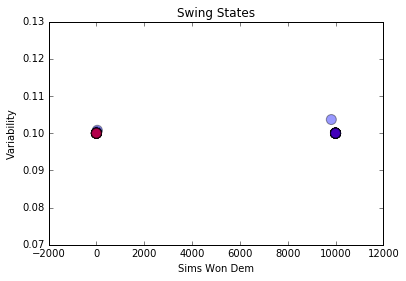

In [70]:
sim.states['swing'] = np.absolute(sim.states['dem'] - sim.states['rep'])
sim.states['color'] = sim.states['dem'] > sim.states['rep']
sim.states['color'] = sim.states['color'].apply(lambda x: 'b' if x else 'r')
output = sim.states.drop(['AK', 'SD'], axis=0)
print output.sort_values(by='swing').head(25)
sizes = (1. / output['swing']) * 1000
plt.scatter(output['dem'], sizes, s=100, alpha=.4, c=sim.states['color'])
plt.title('Swing States')
plt.xlabel('Sims Won Dem')
plt.ylabel('Variability')

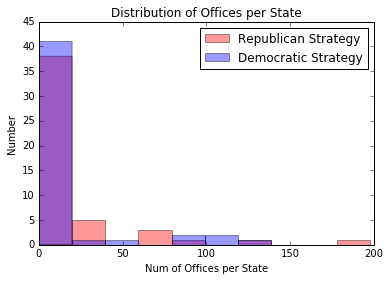

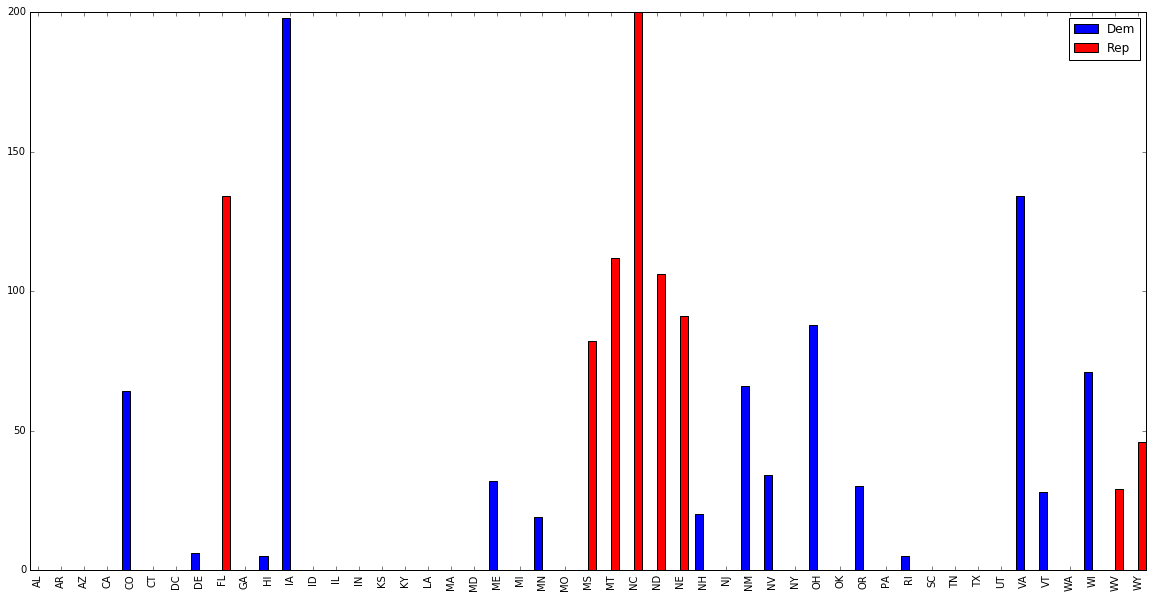

In [71]:
rep_strat = sim.get_strategy(mod_type='rep').groupby('state_abbr').sum()
dem_strat = sim.get_strategy(mod_type='dem').groupby('state_abbr').sum()

n, bins, patches = plt.hist(dem_strat.values, alpha=.4, color='r', label='Republican Strategy')
plt.hist(rep_strat.values, bins=bins, alpha=.4, label='Democratic Strategy')
plt.ylabel('Number')
plt.legend()
plt.xlabel('Num of Offices per State')
plt.title('Distribution of Offices per State')
plt.show()

width = .35

plt.figure(figsize=(20,10))
plt.bar(np.arange(0,49), dem_strat.values, width=width, tick_label=dem_strat.index, label='Dem', color='b', )
plt.bar(np.arange(0,49) + width, rep_strat.values, width=width, tick_label=dem_strat.index, label='Rep', color='r')
plt.xticks(np.arange(0,49) + width,rotation='vertical', )
plt.legend()
plt.show()

In [ ]:
for thresh in np.linspace(0, 1, num=11):
    print thresh
    df = sim.get_strategy(thresh=thresh, mod_type='dem')
    df.hist()
    plt.show()

In [ ]:
a = electoral.set_index('state_abbr').to_dict()['electoral_votes']
a['VA']

In [ ]:
df = obama > obama_1

In [68]:
rep_strat

,strategy
state_abbr,
AL,0
AR,0
AZ,2
CA,0
CO,0
CT,0
DC,0
DE,0
FL,134
